In [ ]:
%pip install beautifulsoup4


Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
  Obtaining dependency information for beautifulsoup4 from https://files.pythonhosted.org/packages/b1/fe/e8c672695b37eecc5cbf43e1d0638d88d66ba3a44c4d321c796f4e59167f/beautifulsoup4-4.12.3-py3-none-any.whl.metadata
  Obtaining dependency information for soupsieve>1.2 from https://files.pythonhosted.org/packages/4c/f3/038b302fdfbe3be7da016777069f26ceefe11a681055ea1f7817546508e3/soupsieve-2.5-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/147.9 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━ 143.4/147.9 kB 4.5 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.9/147.9 kB 3.8 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [ ]:
%pip install textblob


Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
  Obtaining dependency information for textblob from https://files.pythonhosted.org/packages/02/07/5fd2945356dd839974d3a25de8a142dc37293c21315729a41e775b5f3569/textblob-0.18.0.post0-py3-none-any.whl.metadata
  Obtaining dependency information for nltk>=3.8 from https://files.pythonhosted.org/packages/a6/0a/0d20d2c0f16be91b9fa32a77b76c60f9baf6eba419e5ef5deca17af9c582/nltk-3.8.1-py3-none-any.whl.metadata
  Obtaining dependency information for regex>=2021.8.3 from https://files.pythonhosted.org/packages/39/29/8158a6e69e97b9c72fab0b46fe4d57c789d07ef91fe4afde23721e7cac61/regex-2024.5.15-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/40.9 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 1.8 MB/s eta 0:00:00
  Obtaining dependency information for tqdm from https://files.pytho

In [ ]:
dbutils.library.restartPython()




In [ ]:


import boto3
import logging
from pyspark.sql import SparkSession
from io import BytesIO
from warcio.archiveiterator import ArchiveIterator
from bs4 import BeautifulSoup
from pyspark.sql.functions import col, split, size, udf
from pyspark.sql.types import StringType
from textblob import TextBlob

# Configure logging
logging.basicConfig(level=logging.INFO, filename='process.log', filemode='a',
                    format='%(asctime)s - %(levelname)s - %(message)s')
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)
console_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))
logging.getLogger().addHandler(console_handler)

logging.info("Libraries imported and logging configured")


# Configure Spark to increase memory
try:
    spark = SparkSession.builder \
        .appName("CommonCrawlExample") \
        .config("spark.driver.memory", "8g") \
        .config("spark.executor.memory", "8g") \
        .config("spark.driver.maxResultSize", "4g") \
        .getOrCreate()
    logging.info("Spark session initialized successfully")
except Exception as e:
    logging.error(f"Error initializing Spark session: {e}")



2024-06-28 00:03:13,904 - INFO - Libraries imported and logging configured
2024-06-28 00:03:13,923 - INFO - Spark session initialized successfully


In [ ]:
dbutils.library.restartPython()

In [ ]:
# AWS credentials

# Initialize a session using Amazon S3
s3 = boto3.client('s3', aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_access_key)

# Define the S3 bucket and a sample WARC file key
bucket = 'commoncrawl'
sample_key = 'crawl-data/CC-MAIN-2013-20/segments/1368696381249/warc/CC-MAIN-20130516092621-00000-ip-10-60-113-184.ec2.internal.warc.gz'

# Function to read WARC files from S3
def read_warc_file(s3_client, bucket, key, max_records=100):
    logging.info(f"Reading WARC file from S3 bucket: {bucket}, key: {key}")
    response = s3_client.get_object(Bucket=bucket, Key=key)
    raw_data = response['Body'].read()
    stream = BytesIO(raw_data)
    records = []
    for record in ArchiveIterator(stream):
        if record.rec_type == 'response' and len(records) < max_records:
            payload = record.content_stream().read()
            records.append(payload.decode('utf-8', errors='ignore'))
    logging.info(f"Read {len(records)} records from WARC file")
    return records

# Function to extract text from HTML content
def extract_text(html_content):
    try:
        soup = BeautifulSoup(html_content, 'html.parser')
        text = soup.get_text(separator=' ', strip=True)
        return text if text else None
    except Exception as e:
        logging.error(f"Error parsing HTML content: {e}")
        return None

# Register the UDF for text extraction
extract_text_udf = udf(extract_text, StringType())
logging.info("UDF for extracting text from HTML content registered successfully")

# Function to process chunks of WARC data
def process_warc_chunks(s3_client, bucket, key, chunk_size=10):
    warc_records = read_warc_file(s3_client, bucket, key, max_records=100)
    df = spark.createDataFrame([(r,) for r in warc_records], ["content"])
    df_text = df.withColumn('text', extract_text_udf(df['content']))
    df_text = df_text.dropna(subset=['text'])
    df_text = df_text.withColumn('word_count', size(split(df_text['text'], ' ')))
    df_text.show(5, truncate=False)
    logging.info("Text extracted, null values dropped, and word count added successfully")
    return df_text

# Processing WARC file in chunks
try:
    df_text = process_warc_chunks(s3, bucket, sample_key, chunk_size=10)
except Exception as e:
    logging.error(f"Error in the chunk processing function: {e}")

# Define a UDF to determine sentiment
def sentiment_analysis(text):
    testimonial = TextBlob(text)
    polarity = testimonial.sentiment.polarity
    if polarity > 0:
        return 'positive'
    elif polarity == 0:
        return 'neutral'
    else:
        return 'negative'

# Register the sentiment analysis UDF
sentiment_udf = udf(sentiment_analysis, StringType())

# Apply the UDF to your DataFrame
try:
    df_with_sentiment = df_text.withColumn('sentiment', sentiment_udf(df_text['text']))
    df_with_sentiment.show(5)
    logging.info("Sentiment analysis applied and results displayed successfully")
except Exception as e:
    logging.error(f"Error applying sentiment analysis: {e}")

# Save the DataFrame to a CSV file for further analysis
output_path = "dbfs:/output/warc_data_with_sentiment1.csv"
try:
    df_with_sentiment.write.csv(output_path, header=True, mode='overwrite')
    logging.info(f"Data saved successfully to {output_path}")
except Exception as e:
    logging.error(f"Error saving data to CSV: {e}")


2024-06-28 00:03:22,611 - INFO - Received command c on object id p0
2024-06-28 00:03:23,008 - INFO - UDF for extracting text from HTML content registered successfully
2024-06-28 00:03:23,010 - INFO - Reading WARC file from S3 bucket: commoncrawl, key: crawl-data/CC-MAIN-2013-20/segments/1368696381249/warc/CC-MAIN-20130516092621-00000-ip-10-60-113-184.ec2.internal.warc.gz
2024-06-28 00:04:54,678 - INFO - Read 100 records from WARC file
2024-06-28 00:04:57,698 - INFO - Text extracted, null values dropped, and word count added successfully


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

2024-06-28 00:04:59,513 - INFO - Sentiment analysis applied and results displayed successfully


+--------------------+--------------------+----------+---------+
|             content|                text|word_count|sentiment|
+--------------------+--------------------+----------+---------+
|<!doctype html>\r...|How-AP-reported-i...|       872| positive|
| JFIF       ...| JFIF       ...|        70| negative|
|<!-- saved from u...|North Star Writer...|      2129| positive|
|<html><style type...|Rogue's Gallery (...|       735| positive|
|<?xml version="1....|Photos [ style: d...|       126| positive|
+--------------------+--------------------+----------+---------+
only showing top 5 rows



2024-06-28 00:05:08,495 - INFO - Data saved successfully to dbfs:/output/warc_data_with_sentiment1.csv


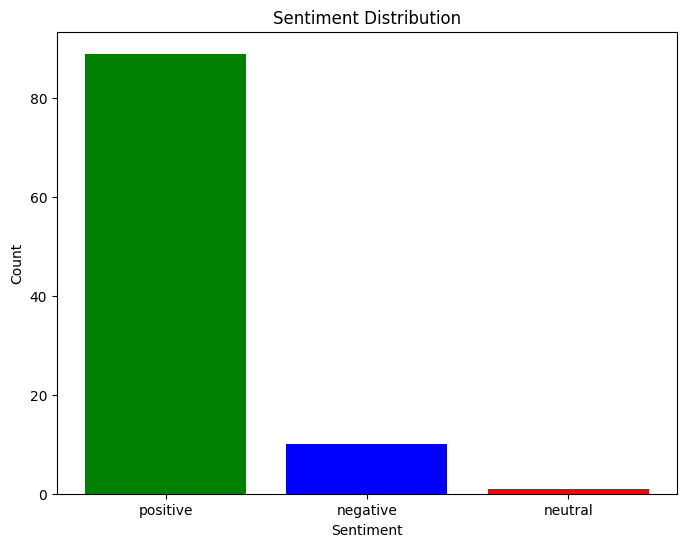

In [ ]:
import matplotlib.pyplot as plt
# Count the number of positive, neutral, and negative sentiments
sentiment_counts = df_with_sentiment.groupBy('sentiment').count().collect()
sentiment_labels = [row['sentiment'] for row in sentiment_counts]
sentiment_values = [row['count'] for row in sentiment_counts]

# Plot the sentiment distribution
plt.figure(figsize=(8, 6))
plt.bar(sentiment_labels, sentiment_values, color=['green', 'blue', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

In [ ]:
from pyspark.ml.feature import CountVectorizer, IDF, Tokenizer, StopWordsRemover
from pyspark.ml.clustering import LDA
from pyspark.sql.functions import regexp_replace, udf
from pyspark.sql.types import ArrayType, StringType
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk

nltk.download('wordnet')
nltk.download('omw-1.4')

# Additional text cleaning
df_cleaned = df_with_sentiment.withColumn('text', regexp_replace(col('text'), '[^\w\s]', ''))
df_cleaned = df_cleaned.withColumn('text', regexp_replace(col('text'), '\s+', ' '))

# Tokenize the text column
tokenizer = Tokenizer(inputCol="text", outputCol="words")
df_words = tokenizer.transform(df_cleaned)

# Remove stopwords and single characters
stopwords = StopWordsRemover.loadDefaultStopWords('english') + ["o", "e", "c", "d", "b", "q", "n", "f", "m", "500", "2012", "pm"]
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words", stopWords=stopwords)
df_filtered = remover.transform(df_words)

# Lemmatization function
lemmatizer = WordNetLemmatizer()

def lemmatize_words(words):
    return [lemmatizer.lemmatize(word) for word in words if len(word) > 1]

lemmatize_udf = udf(lemmatize_words, ArrayType(StringType()))

df_lemmatized = df_filtered.withColumn("lemmatized_words", lemmatize_udf(col("filtered_words")))

# Apply CountVectorizer to the lemmatized words
cv = CountVectorizer(inputCol='lemmatized_words', outputCol='features', vocabSize=10000, minDF=5)
cv_model = cv.fit(df_lemmatized)
df_cv = cv_model.transform(df_lemmatized)

# Apply IDF to the CountVectorizer results
idf = IDF(inputCol='features', outputCol='idf_features')
idf_model = idf.fit(df_cv)
df_tfidf = idf_model.transform(df_cv)

# Fit LDA model
lda = LDA(k=4, maxIter=10, featuresCol='idf_features')  # Experimenting with 4 topics
lda_model = lda.fit(df_tfidf)

# Show topics
topics = lda_model.describeTopics()
vocab = cv_model.vocabulary
topics_rdd = topics.rdd
topics_words = topics_rdd.map(lambda row: [vocab[idx] for idx in row['termIndices']]).collect()

print("Topics and their words:")
for idx, topic in enumerate(topics_words):
    print(f"Topic {idx + 1}: {', '.join(topic)}")


2024-06-27 17:37:48,724 - INFO - Received command c on object id p0
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Topics and their words:
Topic 1: blue, video, 2009, song, football, guy, play, love, 2013, concert
Topic 2: deal, location, street, technology, session, day, please, video, website, tech
Topic 3: 1000, mark, de, photo, account, 800, 500px, ago, starter, brian
Topic 4: message, location, machine, reply, available, website, print, date, steve, art


2024-06-27 17:50:08,232 - INFO - Received command c on object id p0


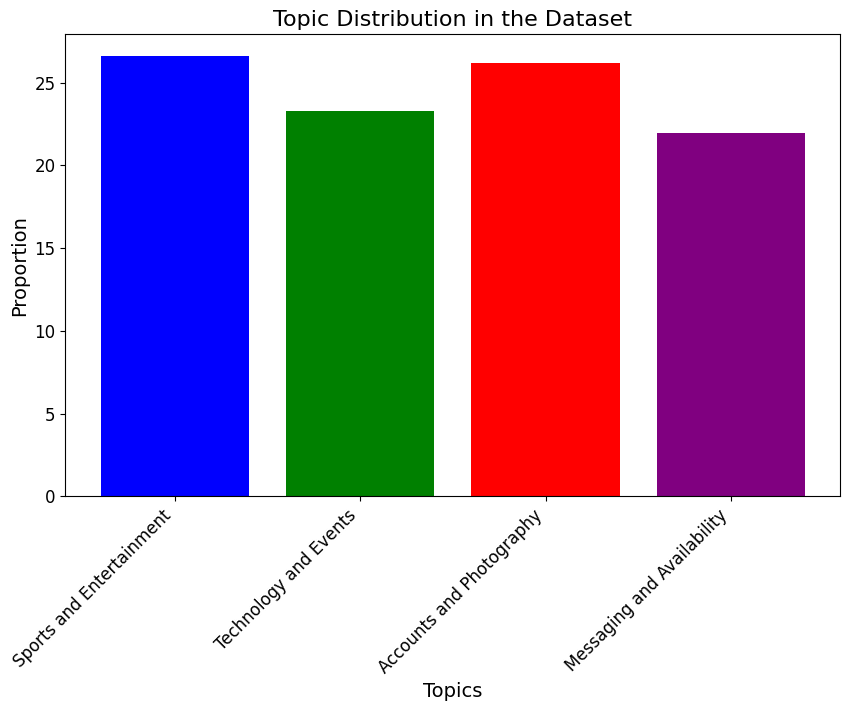

In [ ]:
# Manually assign topic names based on the identified themes
topic_names = {
    0: "Sports and Entertainment",
    1: "Technology and Events",
    2: "Accounts and Photography",
    3: "Messaging and Availability"
}

# Show topics with assigned names
topics = lda_model.describeTopics()
vocab = cv_model.vocabulary
topics_rdd = topics.rdd
topics_words = topics_rdd.map(lambda row: [vocab[idx] for idx in row['termIndices']]).collect()

import matplotlib.pyplot as plt
import numpy as np

# Summarize topic distributions
topic_sums = np.sum(topic_distributions, axis=0)
topic_labels = [topic_names[i] for i in range(len(topic_sums))]

# Plot the topic distribution
plt.figure(figsize=(10, 6))  # Increase the figure size
bars = plt.bar(topic_labels, topic_sums, color=['blue', 'green', 'red', 'purple'])

# Add space between the bars
for bar in bars:
    bar.set_width(0.8)

plt.xlabel('Topics', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.title('Topic Distribution in the Dataset', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.show()



In [ ]:
# Define UDF to get the dominant topic for each document
def get_dominant_topic_name(topic_dist):
    return topic_names[int(np.argmax(topic_dist))]

dominant_topic_udf = udf(get_dominant_topic_name, StringType())

# Add dominant topic to DataFrame
df_with_dominant_topic = df_topics.withColumn("dominant_topic", dominant_topic_udf(col("topicDistribution")))

# Drop unsupported columns before saving
df_to_save = df_with_dominant_topic.drop("words").drop("filtered_words").drop("lemmatized_words").drop("features").drop("idf_features").drop("topicDistribution")

# Show some documents with their dominant topics to confirm
df_to_save.select("content", "text", "word_count", "sentiment", "dominant_topic").show(10, truncate=False)

# Save the DataFrame with sentiment analysis and dominant topics to a CSV file
output_path = "dbfs:/output/warc_data_with_sentiment_and_topics.csv"
try:
    df_to_save.write.csv(output_path, header=True, mode='overwrite')
    logging.info(f"Data saved successfully to {output_path}")
except Exception as e:
    logging.error(f"Error saving data to CSV: {e}")

# Log the completion of the script
logging.info("Script completed.")
print("Script completed.")


2024-06-27 22:26:48,659 - INFO - Received command c on object id p0


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

2024-06-27 22:27:07,964 - INFO - Data saved successfully to dbfs:/output/warc_data_with_sentiment_and_topics.csv
2024-06-27 22:27:07,964 - INFO - Data saved successfully to dbfs:/output/warc_data_with_sentiment_and_topics.csv
2024-06-27 22:27:07,968 - INFO - Script completed.
2024-06-27 22:27:07,968 - INFO - Script completed.


Script completed.
